In [ ]:
import os
import torch
import json
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from PIL import Image, ImageOps
import copy

In [ ]:
train_json_path = 'mpii/annotations/mpii_train.json'
test_json_path = 'mpii/annotations/mpii_test.json'
val_json_path = 'mpii/annotations/mpii_val.json'
images_path = 'mpii/images'

In [ ]:
with open(train_json_path) as f:
    train_json = json.load(f)
# with open(test_json_path) as f:
#     test_json = json.load(f)
with open(val_json_path) as f:
    test_json = json.load(f)

In [ ]:
train_images = []
train_scales = []
train_centers = []
train_joints_vis = []
train_joints = []
for img in train_json:
    train_images.append(img['image'])
    train_scales.append(img['scale'])
    train_centers.append(img['center'])
    train_joints_vis.append(img['joints_vis'])
    train_joints.append(img['joints'])
train_joints = np.asarray(train_joints)

In [ ]:
test_images = []
test_scales = []
test_centers = []
test_joints_vis = []
test_joints = []
for img in test_json:
    test_images.append(img['image'])
    test_scales.append(img['scale'])
    test_centers.append(img['center'])
    test_joints_vis.append(img['joints_vis'])
    test_joints.append(img['joints'])
test_joints = np.asarray(test_joints)

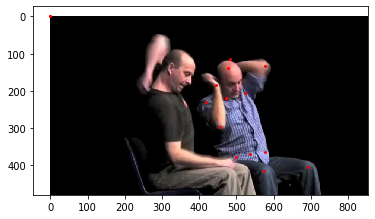

In [ ]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=15, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
index = 20
show_landmarks(io.imread(os.path.join(images_path, train_images[index])), train_joints[index])
plt.show()

In [ ]:
class PoseDataset(Dataset):
    def __init__(self, images, labels, scales, centers, root_dir, transform=None):

        self.images = images
        self.landmarks = labels
        self.scales = scales
        self.centers = centers
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)

    def crop_man(self, sample, scale_man, center_man):
        image, landmarks = sample[0], sample[1]

        h, w = image.shape[:2]
        
        h_add, v_add = 0, 0

        top = int(center_man[1] - scale_man*105)
        if top < 0:
            h_add = int(-top)
            top = 0
        left = int(center_man[0] - scale_man*60)
        if left < 0:
            v_add = int(-left)
            left = 0

        image = image[top: top + int(scale_man*210) - h_add,
                      left: left + int(scale_man*120) - v_add]

        landmarks = landmarks - [left, top]
        for i, landmark in enumerate(landmarks):
            if landmark[0] < 0 or landmark[1] < 0:
                landmarks[i] = [-1, -1]

        return (image, landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.images[idx])
        image = io.imread(img_name)
        landmarks = self.landmarks[idx]
        sample = (image, landmarks)
        scale_man = self.scales[idx]
        center_man = self.centers[idx]

        sample = self.crop_man(sample, scale_man, center_man)

        if self.transform:
            sample = self.transform(sample)
          
            if type(sample[0]) == torch.Tensor:
                norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                norm(sample[0])

        return sample

In [ ]:
class Resize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample[0], sample[1]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return [img, landmarks]

class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample[0], sample[1]
        image = image.transpose((2, 0, 1))
#         image = image.astype('float32')
#         landmarks = landmarks.astype('float32')
        return (torch.from_numpy(image), torch.from_numpy(landmarks))

class SquarePad(object):
  def __init__(self, targetSize):
    self.targetSize = int(targetSize)

  def __call__(self, sample):
    image, landmarks = sample[0], sample[1]
    targetSize = self.targetSize

    if max(image.shape) < targetSize:
      image = Image.fromarray(image)
      old_size = image.size

      ratio = float(targetSize)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])

      image = image.resize(new_size, Image.ANTIALIAS)
      image = np.asarray(image)
      landmarks = landmarks * ratio

    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    c, h, w = image.shape

    hp, vp = 0, 0
    if w < targetSize:
      hp = int((targetSize - w) / 2)
    if h < targetSize:
      vp = int((targetSize - h) / 2)
    padding = (hp, hp, vp, vp)
  
    image = F.pad(image, padding, 'constant', 0).numpy()
    image = image.transpose((1, 2, 0))
    landmarks = landmarks + [hp, vp]
    return [image, landmarks]

In [ ]:
pose_dataset = PoseDataset(images=train_images, labels=train_joints, scales=train_scales,
                           centers=train_centers, root_dir=images_path,
                           transform=transforms.Compose([SquarePad(256), Resize(256), ToTensor()]))
# pose_dataset = PoseDataset(images=train_images, labels=train_joints, scales=train_scales,
#                            centers=train_centers, root_dir=images_path,
#                            transform=transforms.Compose([Resize(256), ToTensor()]))

In [ ]:
test_data = PoseDataset(images=test_images, labels=test_joints, scales=test_scales,
                           centers=test_centers, root_dir=images_path,
                           transform=transforms.Compose([SquarePad(256), Resize(256), ToTensor()]))

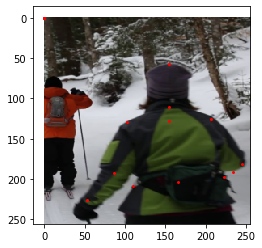

In [ ]:
plt.figure()
toImg = transforms.ToPILImage()
index = 89
show_landmarks(toImg(test_data[index][0].type(torch.FloatTensor)), test_data[index][1])
plt.show()

In [ ]:
train_data, val_data = torch.utils.data.random_split(pose_dataset, [20000, 2246])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
# Reference: https://github.com/Naman-ntc/Pytorch-Human-Pose-Estimation/blob/master/models/modules/StackedHourGlass.py

class BnReluConv(nn.Module):
		"""docstring for BnReluConv"""
		def __init__(self, inChannels, outChannels, kernelSize = 1, stride = 1, padding = 0):
				super(BnReluConv, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				self.kernelSize = kernelSize
				self.stride = stride
				self.padding = padding

				self.bn = nn.BatchNorm2d(self.inChannels)
				self.conv = nn.Conv2d(self.inChannels, self.outChannels, self.kernelSize, self.stride, self.padding)
				self.relu = nn.ReLU()

		def forward(self, x):
				x = self.bn(x)
				x = self.relu(x)
				x = self.conv(x)
				return x


class ConvBlock(nn.Module):
		"""docstring for ConvBlock"""
		def __init__(self, inChannels, outChannels):
				super(ConvBlock, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				self.outChannelsby2 = outChannels//2

				self.cbr1 = BnReluConv(self.inChannels, self.outChannelsby2, 1, 1, 0)
				self.cbr2 = BnReluConv(self.outChannelsby2, self.outChannelsby2, 3, 1, 1)
				self.cbr3 = BnReluConv(self.outChannelsby2, self.outChannels, 1, 1, 0)

		def forward(self, x):
				x = self.cbr1(x)
				x = self.cbr2(x)
				x = self.cbr3(x)
				return x

class SkipLayer(nn.Module):
		"""docstring for SkipLayer"""
		def __init__(self, inChannels, outChannels):
				super(SkipLayer, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				if (self.inChannels == self.outChannels):
						self.conv = None
				else:
						self.conv = nn.Conv2d(self.inChannels, self.outChannels, 1)

		def forward(self, x):
				if self.conv is not None:
						x = self.conv(x)
				return x

class Residual(nn.Module):
		"""docstring for Residual"""
		def __init__(self, inChannels, outChannels):
				super(Residual, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				self.cb = ConvBlock(inChannels, outChannels)
				self.skip = SkipLayer(inChannels, outChannels)

		def forward(self, x):
				out = 0
				out = out + self.cb(x)
				out = out + self.skip(x)
				return out

In [ ]:
# Reference: https://github.com/Naman-ntc/Pytorch-Human-Pose-Estimation/blob/master/models/StackedHourGlass.py

class myUpsample(nn.Module):
	def __init__(self):
		super(myUpsample, self).__init__()
		pass
	def forward(self, x):
		return x[:, :, :, None, :, None].expand(-1, -1, -1, 2, -1, 2).reshape(x.size(0), x.size(1), x.size(2)*2, x.size(3)*2)
        
        
class Hourglass(nn.Module):
    """docstring for Hourglass"""
    def __init__(self, nChannels = 256, numReductions = 4, nModules = 2, poolKernel = (2,2), poolStride = (2,2), upSampleKernel = 2):
        super(Hourglass, self).__init__()
        self.numReductions = numReductions
        self.nModules = nModules
        self.nChannels = nChannels
        self.poolKernel = poolKernel
        self.poolStride = poolStride
        self.upSampleKernel = upSampleKernel
        """
        For the skip connection, a residual module (or sequence of residuaql modules)
        """

        _skip = []
        for _ in range(self.nModules):
            _skip.append(Residual(self.nChannels, self.nChannels))

        self.skip = nn.Sequential(*_skip)

        """
        First pooling to go to smaller dimension then pass input through
        Residual Module or sequence of Modules then  and subsequent cases:
            either pass through Hourglass of numReductions-1
            or pass through Residual Module or sequence of Modules
        """

        self.mp = nn.MaxPool2d(self.poolKernel, self.poolStride)

        _afterpool = []
        for _ in range(self.nModules):
            _afterpool.append(Residual(self.nChannels, self.nChannels))

        self.afterpool = nn.Sequential(*_afterpool)

        if (numReductions > 1):
            self.hg = Hourglass(self.nChannels, self.numReductions-1, self.nModules, self.poolKernel, self.poolStride)
        else:
            _num1res = []
            for _ in range(self.nModules):
                _num1res.append(Residual(self.nChannels,self.nChannels))

            self.num1res = nn.Sequential(*_num1res)  # doesnt seem that important ?

        """
        Now another Residual Module or sequence of Residual Modules
        """

        _lowres = []
        for _ in range(self.nModules):
            _lowres.append(Residual(self.nChannels,self.nChannels))

        self.lowres = nn.Sequential(*_lowres)

        """
        Upsampling Layer (Can we change this??????)
        As per Newell's paper upsamping recommended
        """
        self.up = myUpsample()#nn.Upsample(scale_factor = self.upSampleKernel)


    def forward(self, x):
        out1 = x
        out1 = self.skip(out1)
        out2 = x
        out2 = self.mp(out2)
        out2 = self.afterpool(out2)
        if self.numReductions>1:
            out2 = self.hg(out2)
        else:
            out2 = self.num1res(out2)
        out2 = self.lowres(out2)
        out2 = self.up(out2)

        return out2 + out1


class StackedHourGlass(nn.Module):
	"""docstring for StackedHourGlass"""
	def __init__(self, nChannels, nStack, nModules, numReductions, nJoints):
		super(StackedHourGlass, self).__init__()
		self.nChannels = nChannels
		self.nStack = nStack
		self.nModules = nModules
		self.numReductions = numReductions
		self.nJoints = nJoints

		self.start = BnReluConv(3, 64, kernelSize = 7, stride = 2, padding = 3)

		self.res1 = Residual(64, 128)
		self.mp = nn.MaxPool2d(2, 2)
		self.res2 = Residual(128, 128)
		self.res3 = Residual(128, self.nChannels)

		_hourglass, _Residual, _lin1, _chantojoints, _lin2, _jointstochan = [],[],[],[],[],[]

		for _ in range(self.nStack):
			_hourglass.append(Hourglass(self.nChannels, self.numReductions, self.nModules))
			_ResidualModules = []
			for _ in range(self.nModules):
				_ResidualModules.append(Residual(self.nChannels, self.nChannels))
			_ResidualModules = nn.Sequential(*_ResidualModules)
			_Residual.append(_ResidualModules)
			_lin1.append(BnReluConv(self.nChannels, self.nChannels))
			_chantojoints.append(nn.Conv2d(self.nChannels, self.nJoints,1))
			_lin2.append(nn.Conv2d(self.nChannels, self.nChannels,1))
			_jointstochan.append(nn.Conv2d(self.nJoints,self.nChannels,1))

		self.hourglass = nn.ModuleList(_hourglass)
		self.Residual = nn.ModuleList(_Residual)
		self.lin1 = nn.ModuleList(_lin1)
		self.chantojoints = nn.ModuleList(_chantojoints)
		self.lin2 = nn.ModuleList(_lin2)
		self.jointstochan = nn.ModuleList(_jointstochan)

	def forward(self, x):
		x = self.start(x)
		x = self.res1(x)
		x = self.mp(x)
		x = self.res2(x)
		x = self.res3(x)
		out = []

		for i in range(self.nStack):
			x1 = self.hourglass[i](x)
			x1 = self.Residual[i](x1)
			x1 = self.lin1[i](x1)
			out.append(self.chantojoints[i](x1))
			x1 = self.lin2[i](x1)
			x = x + x1 + self.jointstochan[i](out[i])

		return (out)

In [ ]:
class OurStackedHourGlass(nn.Module):
  def __init__(self, nChannels, nStack, nModules, numReductions, nJoints):
    super(OurStackedHourGlass, self).__init__()
    self.nChannels = nChannels
    self.nStack = nStack
    self.nModules = nModules
    self.numReductions = numReductions
    self.nJoints = nJoints

    self.first = BnReluConv(3, 64, kernelSize = 7, stride = 2, padding = 3)
    self.second = BnReluConv(64, 64, kernelSize = 3, stride = 1, padding = 1)
    self.third = BnReluConv(64, 128, kernelSize = 1, stride = 1, padding = 0)
    self.mp = nn.MaxPool2d(2, 2)
    self.fourth = BnReluConv(128, 128, kernelSize = 3, stride = 1, padding = 1)
    self.fifth = BnReluConv(128, self.nChannels, kernelSize = 1, stride = 1, padding = 0)

    _hourglass, _Residual, _lin1, _chantojoints, _lin2, _jointstochan = [],[],[],[],[],[]

    for _ in range(self.nStack):
      _hourglass.append(Hourglass(self.nChannels, self.numReductions, self.nModules))
      _ResidualModules = []
      for _ in range(self.nModules):
        _ResidualModules.append(Residual(self.nChannels, self.nChannels))
      _ResidualModules = nn.Sequential(*_ResidualModules)
      _Residual.append(_ResidualModules)
      _lin1.append(BnReluConv(self.nChannels, self.nChannels))
      _chantojoints.append(nn.Conv2d(self.nChannels, self.nJoints,1))
      _lin2.append(nn.Conv2d(self.nChannels, self.nChannels,1))
      _jointstochan.append(nn.Conv2d(self.nJoints,self.nChannels,1))

    self.hourglass = nn.ModuleList(_hourglass)
    self.Residual = nn.ModuleList(_Residual)
    self.lin1 = nn.ModuleList(_lin1)
    self.chantojoints = nn.ModuleList(_chantojoints)
    self.lin2 = nn.ModuleList(_lin2)
    self.jointstochan = nn.ModuleList(_jointstochan)

  def forward(self, x):
    x = self.first(x)
    x = self.second(x)
    x = self.third(x)
    x = self.mp(x)
    x = self.fourth(x)
    x = self.fifth(x)
    out = []

    for i in range(self.nStack):
      x1 = self.hourglass[i](x)
      x1 = self.Residual[i](x1)
      x1 = self.lin1[i](x1)
      out.append(self.chantojoints[i](x1))
      x1 = self.lin2[i](x1)
      x = x + x1 + self.jointstochan[i](out[i])

    return (out)

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.stackedHG = OurStackedHourGlass(nChannels=256, nStack=2, nModules=2, numReductions=4, nJoints=16)

    def forward(self, x):
        x = self.stackedHG(x)
        return x

In [ ]:
class HeatmapGenerator():
    def __init__(self, output_res, num_joints, sigma=-1):
        self.output_res = output_res
        self.num_joints = num_joints
        if sigma < 0:
            sigma = self.output_res/64
        self.sigma = sigma
        size = 6*sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0, y0 = 3*sigma + 1, 3*sigma + 1
        self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    def __call__(self, joints):
        hms = np.zeros((joints.shape[0], self.num_joints, self.output_res, self.output_res),
                       dtype=np.float64)
        sigma = self.sigma
        for i, p in enumerate(joints):
            for idx, pt in enumerate(p):
#                 if pt[2] > 0:
                    if pt[0] < 0 or pt[1] < 0 or \
                       pt[0] >= self.output_res*4 or pt[1] >= self.output_res*4:
                        continue
                    x, y = int(pt[0])//4, int(pt[1])//4

                    ul = int(np.round(x - 3 * sigma - 1)), int(np.round(y - 3 * sigma - 1))
                    br = int(np.round(x + 3 * sigma + 2)), int(np.round(y + 3 * sigma + 2))

                    c, d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                    a, b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                    cc, dd = max(0, ul[0]), min(br[0], self.output_res)
                    aa, bb = max(0, ul[1]), min(br[1], self.output_res)
                    hms[i, idx, aa:bb, cc:dd] = np.maximum(
                        hms[i, idx, aa:bb, cc:dd], self.g[a:b, c:d])
        return hms

In [ ]:
heatmap = HeatmapGenerator(64, 16)
for batch_idx, (data, target) in enumerate(test_loader):
    print(target.shape)
    target = torch.from_numpy(heatmap(target))
    print(target.shape)
    break

In [ ]:
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = 0
#         inx = np.zeros(output[0].shape)
#         for a in range(len(target)):
#             for b in range(len(target[a])):
#                 x = target[a][b][0].item()
#                 y = target[a][b][1].item()
#                 x, y = int(min(63, max(0, x//4))), int(min(63, max(0, y//4)))
#                 inx[a][b][x][y] = 1
#         inx = torch.from_numpy(inx).to(device)
        
#         for i in range(len(output)):
#             loss += F.mse_loss(output[i], inx)
#         #loss = F.mse_loss(output, target)
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#     train_loss_list.append(train_loss/len(train_loader))

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = 0
#         inx = np.zeros(output[0].shape)
#         for a in range(len(target)):
#             for b in range(len(target[a])):
#                 x = target[a][b][0].item()
#                 y = target[a][b][1].item()
#                 x, y = int(min(63, max(0, x//4))), int(min(63, max(0, y//4)))
#                 inx[a][b][x][y] = 1
#         inx = torch.from_numpy(inx).to(device)
        
#         for i in range(len(output)):
#             loss += F.mse_loss(output[i], inx)
#         #loss = F.mse_loss(output, target)
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#     train_loss_list.append(train_loss/len(train_loader))

def train(model, device, train_loader, val_loader, optimizer, epochs):
    best_model = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        heatmap = HeatmapGenerator(64, 16)
        for batch_idx, (data, target) in enumerate(train_loader):
            target = torch.from_numpy(heatmap(target))
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = 0
            for i in range(len(output)):
                loss += F.mse_loss(output[i], target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                train_loss_list_batch.append(loss.item())        
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_loss_list.append(train_loss/len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = torch.from_numpy(heatmap(target))
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = 0            
                for i in range(len(output)):
                    loss += F.mse_loss(output[i], target)
                val_loss += loss.item()
                
        if val_loss < best_loss:
                best_loss = val_loss
                best_model = copy.deepcopy(model.state_dict())
                
        test_loss_list1.append(val_loss/len(val_loader))
        test_loss_list2.append(val_loss/len(val_loader.dataset))
        print('\Average validation loss: {:.4f} \n'.format(val_loss))
        
    model.load_state_dict(best_model)
    return model

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    heatmap = HeatmapGenerator(64, 16)
    with torch.no_grad():
        for data, target in test_loader:
            target = torch.from_numpy(heatmap(target))
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = 0            
            for i in range(len(output)):
                loss += F.mse_loss(output[i], target)
            test_loss += loss.item()
            
#             pred = output[0].argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)
    print('\nTest set: Average loss: {:.4f} \n'.format(test_loss))
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
train_loss_list = []
train_loss_list_batch = []
test_loss_list1 = []
test_loss_list2 = []

model = Network().to(device)
model = model.double()

# optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

model = train(model, device, train_loader, val_loader, optimizer, epochs)

torch.save(model.state_dict(),"uniquename.pth")
np.savetxt("uniquename_train_loss_list.csv",  
           train_loss_list, 
           delimiter =", ")
np.savetxt("uniquename_train_loss_list_batch.csv",  
           train_loss_list_batch, 
           delimiter =", ")
np.savetxt("uniquename_test_loss1_list.csv",  
           test_loss_list1, 
           delimiter =", ") 
np.savetxt("uniquename_test_loss2_list.csv",  
           test_loss_list2, 
           delimiter =", ") 

In [ ]:
from datetime import datetime
print('finished', datetime.now())

In [ ]:
plt.rcParams['figure.figsize'] = (9,6)
plt.plot(range(epochs), train_loss_list, 'b', label='train_loss')
plt.plot(range(epochs), test_loss_list1, 'r', label='val_loss')

plt.title('Loss vs Epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12,9)
plt.plot(range325), train_loss_list_batch, 'b', label='train_loss per batch')

plt.title('Loss vs Batch*10')
plt.xlabel('batch*10')
plt.ylabel('loss')
plt.legend()
plt.show()